In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from PIL import Image
from tqdm import tqdm

C:\Users\omalv\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg19', pretrained=True)

Using cache found in C:\Users\omalv/.cache\torch\hub\pytorch_vision_v0.10.0
C:\Users\omalv\.conda\envs\pytorch\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\omalv\.conda\envs\pytorch\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
model.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [50]:
class DeepDream(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = model.eval()
    def forward(self,x):
        for i,layer in enumerate(self.model.features):
            x = layer(x)
            if i == 25:
                return x
            
# 12,7 cool textures
# 28 animals
# 25 buildings and eyes
# 34 wheels

In [41]:
device = "cuda"
size = 512
img = Image.open('tajMahal.webp')
t = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
    ]
) 
# undo the above normalization if and when the need arises 
denormalize = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]),                 
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1., 1., 1. ]),                                                     
                               ])
input_img = t(img).unsqueeze(0).to(device)
input_img.requires_grad=True

In [42]:
dreamer = DeepDream().to(device)

In [57]:
opt = torch.optim.AdamW([input_img],lr=1e-2)
def dream_(img):
    lr = 0.0025
    img_ = t(img).unsqueeze(0).to(device)
    loop =(range(40))
    for i in loop:  
        jitter = 50
        ox = np.random.randint(-jitter,jitter+1)
        oy = np.random.randint(-jitter,jitter+1)
        img = np.roll(np.roll(img_.cpu().detach().squeeze(0).permute(1,2,0).numpy(), ox, 1), oy, 0)
        roll_img = torch.tensor(img).permute(2,0,1).unsqueeze(0).cuda()
        roll_img.requires_grad=True
        out = dreamer(roll_img)
        loss = out[0].norm()
        dreamer.zero_grad()
        loss.backward()
        grads = torch.tensor(np.roll(np.roll(roll_img.grad.detach().cpu().squeeze(0).permute(1,2,0).numpy(), -ox, 1), -oy, 0),device=device).permute(2,0,1).unsqueeze(0).cuda()
        img_.data = img_.data + lr * grads 
    img_out = img_.detach().cpu().squeeze(0)
    img_out = denormalize(img_out)
    img_out_np = img_out.numpy()
    img_out_np = np.clip(img_out_np.transpose(1,2,0),0,1)
    img_out_pil = Image.fromarray(np.uint8(img_out_np * 255))
    return img_out_pil
# print(loss.item())

In [58]:
img = Image.open('lion.jpg')
orig_size = np.array(img.size)
# new_size = np.array(img.size)*0.5
OCTAVE_SCALE = 1.5
for n in tqdm(range(-7,1)):
    new_size = orig_size * (OCTAVE_SCALE**n)
    img = img.resize(new_size.astype(int), Image.LANCZOS)
    # print(img)
    # break
    img = dream_(img)

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:14<00:00,  1.80s/it]


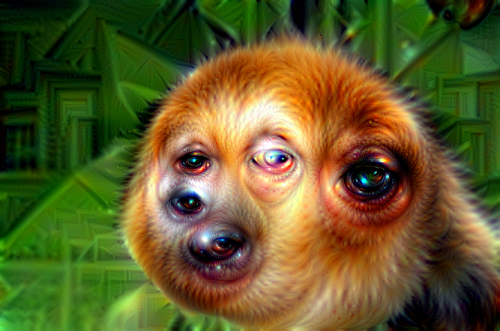

In [59]:
img